In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = "../data/train.csv" # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
N, D = tX.shape

In [3]:
labels = ["DER_mass_MMC","DER_mass_transverse_met_lep","DER_mass_vis","DER_pt_h","DER_deltaeta_jet_jet","DER_mass_jet_jet","DER_prodeta_jet_jet","DER_deltar_tau_lep","DER_pt_tot","DER_sum_pt","DER_pt_ratio_lep_tau","DER_met_phi_centrality","DER_lep_eta_centrality","PRI_tau_pt","PRI_tau_eta","PRI_tau_phi","PRI_lep_pt","PRI_lep_eta","PRI_lep_phi","PRI_met","PRI_met_phi","PRI_met_sumet","PRI_jet_num","PRI_jet_leading_pt","PRI_jet_leading_eta","PRI_jet_leading_phi","PRI_jet_subleading_pt","PRI_jet_subleading_eta","PRI_jet_subleading_phi","PRI_jet_all_pt"]
def feature_label(i):
    return f"Feature {i} ({labels[i]})"

### Exploratory data analysis

Find out how many datapoints are missing for each variable:

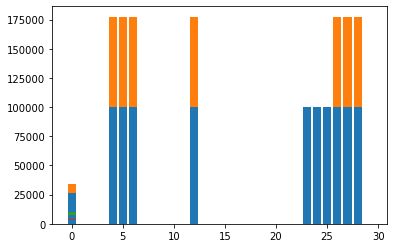

In [4]:
num_jets = labels.index("PRI_jet_num")
by_jet_num = [tX[np.where(tX[:, num_jets] == i)] for i in range(4)]
missing_counts = [np.count_nonzero(group == -999, axis=0) for group in by_jet_num]

plt.bar(np.arange(D), missing_counts[0])
for i in range(1, len(missing_counts)):
    plt.bar(np.arange(D), missing_counts[i], bottom=missing_counts[i-1])
plt.show()

Some notes:
* DER_* features are computed from the PRI_* features. This probably means we should ignore the PRI_* features, since they would most likely directly correlate to the DER_* ones. Luckily, they're already in the right order: there's 13 DER_* variables followed by PRI_* ones.
* All variables are continuous except the prediction and PRI_jet_num, which we shouldn't care about anyways.

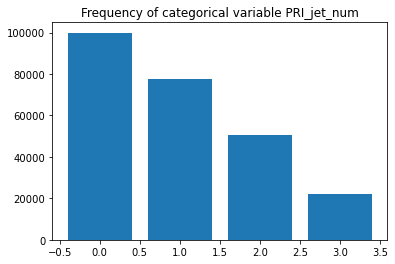

In [5]:
unique, counts = np.unique(tX[:,num_jets], return_counts=True)
plt.bar(unique, counts)
plt.title("Frequency of categorical variable PRI_jet_num")
plt.show()

## Plot data features with respect to each other

In [6]:
def normalize(arr):
    return (arr - np.mean(arr)) / np.std(arr)

def correlate(feature1, feature2, size=None, axs=plt):
    valid = (feature1 != -999) & (feature2 != -999)
    feature1 = normalize(feature1[valid])
    feature2 = normalize(feature2[valid])
    if size is not None:
        perm = np.random.permutation(size)
        feature1 = feature1[perm]
        feature2 = feature2[perm]
    print(np.corrcoef(feature1, feature2))
    axs.scatter(feature1, feature2, s=1.5)

## Which features should me merged together?

In [7]:
def generate_correlation_set(tX, t):
    corr_set = set()
    df = pd.DataFrame(tX)
    corr = df.corr()
    for i, row in enumerate(corr):
        for j, col in enumerate(corr):
            if i != j and corr.loc[i,j] > t:
                corr_set.add((i,j))
                
    return _pairs_to_groups(corr_set)

def _pairs_to_groups(pairs):
    groups = set()
    edges = _create_dict_from_tuples(pairs)
    vertices = edges.keys()
    done = set()

    for vertex in vertices:
        if vertex not in done:
            groups.add(frozenset(_depth_first_search(vertex, edges, done)))

    return groups

def _depth_first_search(vertex, edges, done):
    group = {vertex}
    done.add(vertex)

    for v_adj in edges[vertex]:
        if v_adj not in done:
            group.update(_depth_first_search(v_adj, edges, done))

    return group

def _create_dict_from_tuples(tuples):
    dict_ = dict()

    for x, y in tuples:
        if x not in dict_:
            dict_[x] = set()
        dict_[x].add(y)

    return dict_

In [8]:
generate_correlation_set(tX, 0.96)

{frozenset({23, 24, 25}),
 frozenset({4, 6, 12, 26, 27, 28}),
 frozenset({9, 29})}

## Correlation plots

[[1.         0.22977612]
 [0.22977612 1.        ]]
[[1.         0.91976711]
 [0.91976711 1.        ]]
[[1.         0.01387712]
 [0.01387712 1.        ]]
[[1.         0.00208142]
 [0.00208142 1.        ]]
[[ 1.         -0.00150358]
 [-0.00150358  1.        ]]
[[ 1.        -0.0067416]
 [-0.0067416  1.       ]]
[[1.         0.49569368]
 [0.49569368 1.        ]]
[[ 1.         -0.04305838]
 [-0.04305838  1.        ]]
[[1.        0.0891022]
 [0.0891022 1.       ]]
[[1.         0.01621232]
 [0.01621232 1.        ]]
[[ 1.00000000e+00 -5.45781367e-04]
 [-5.45781367e-04  1.00000000e+00]]
[[ 1.         -0.01763928]
 [-0.01763928  1.        ]]
[[1.         0.22977612]
 [0.22977612 1.        ]]
[[1.         0.15602402]
 [0.15602402 1.        ]]
[[ 1.        -0.2720067]
 [-0.2720067  1.       ]]
[[ 1.         -0.08700988]
 [-0.08700988  1.        ]]
[[ 1.         -0.08186724]
 [-0.08186724  1.        ]]
[[1.         0.06908024]
 [0.06908024 1.        ]]
[[1.         0.05296391]
 [0.05296391 1.      

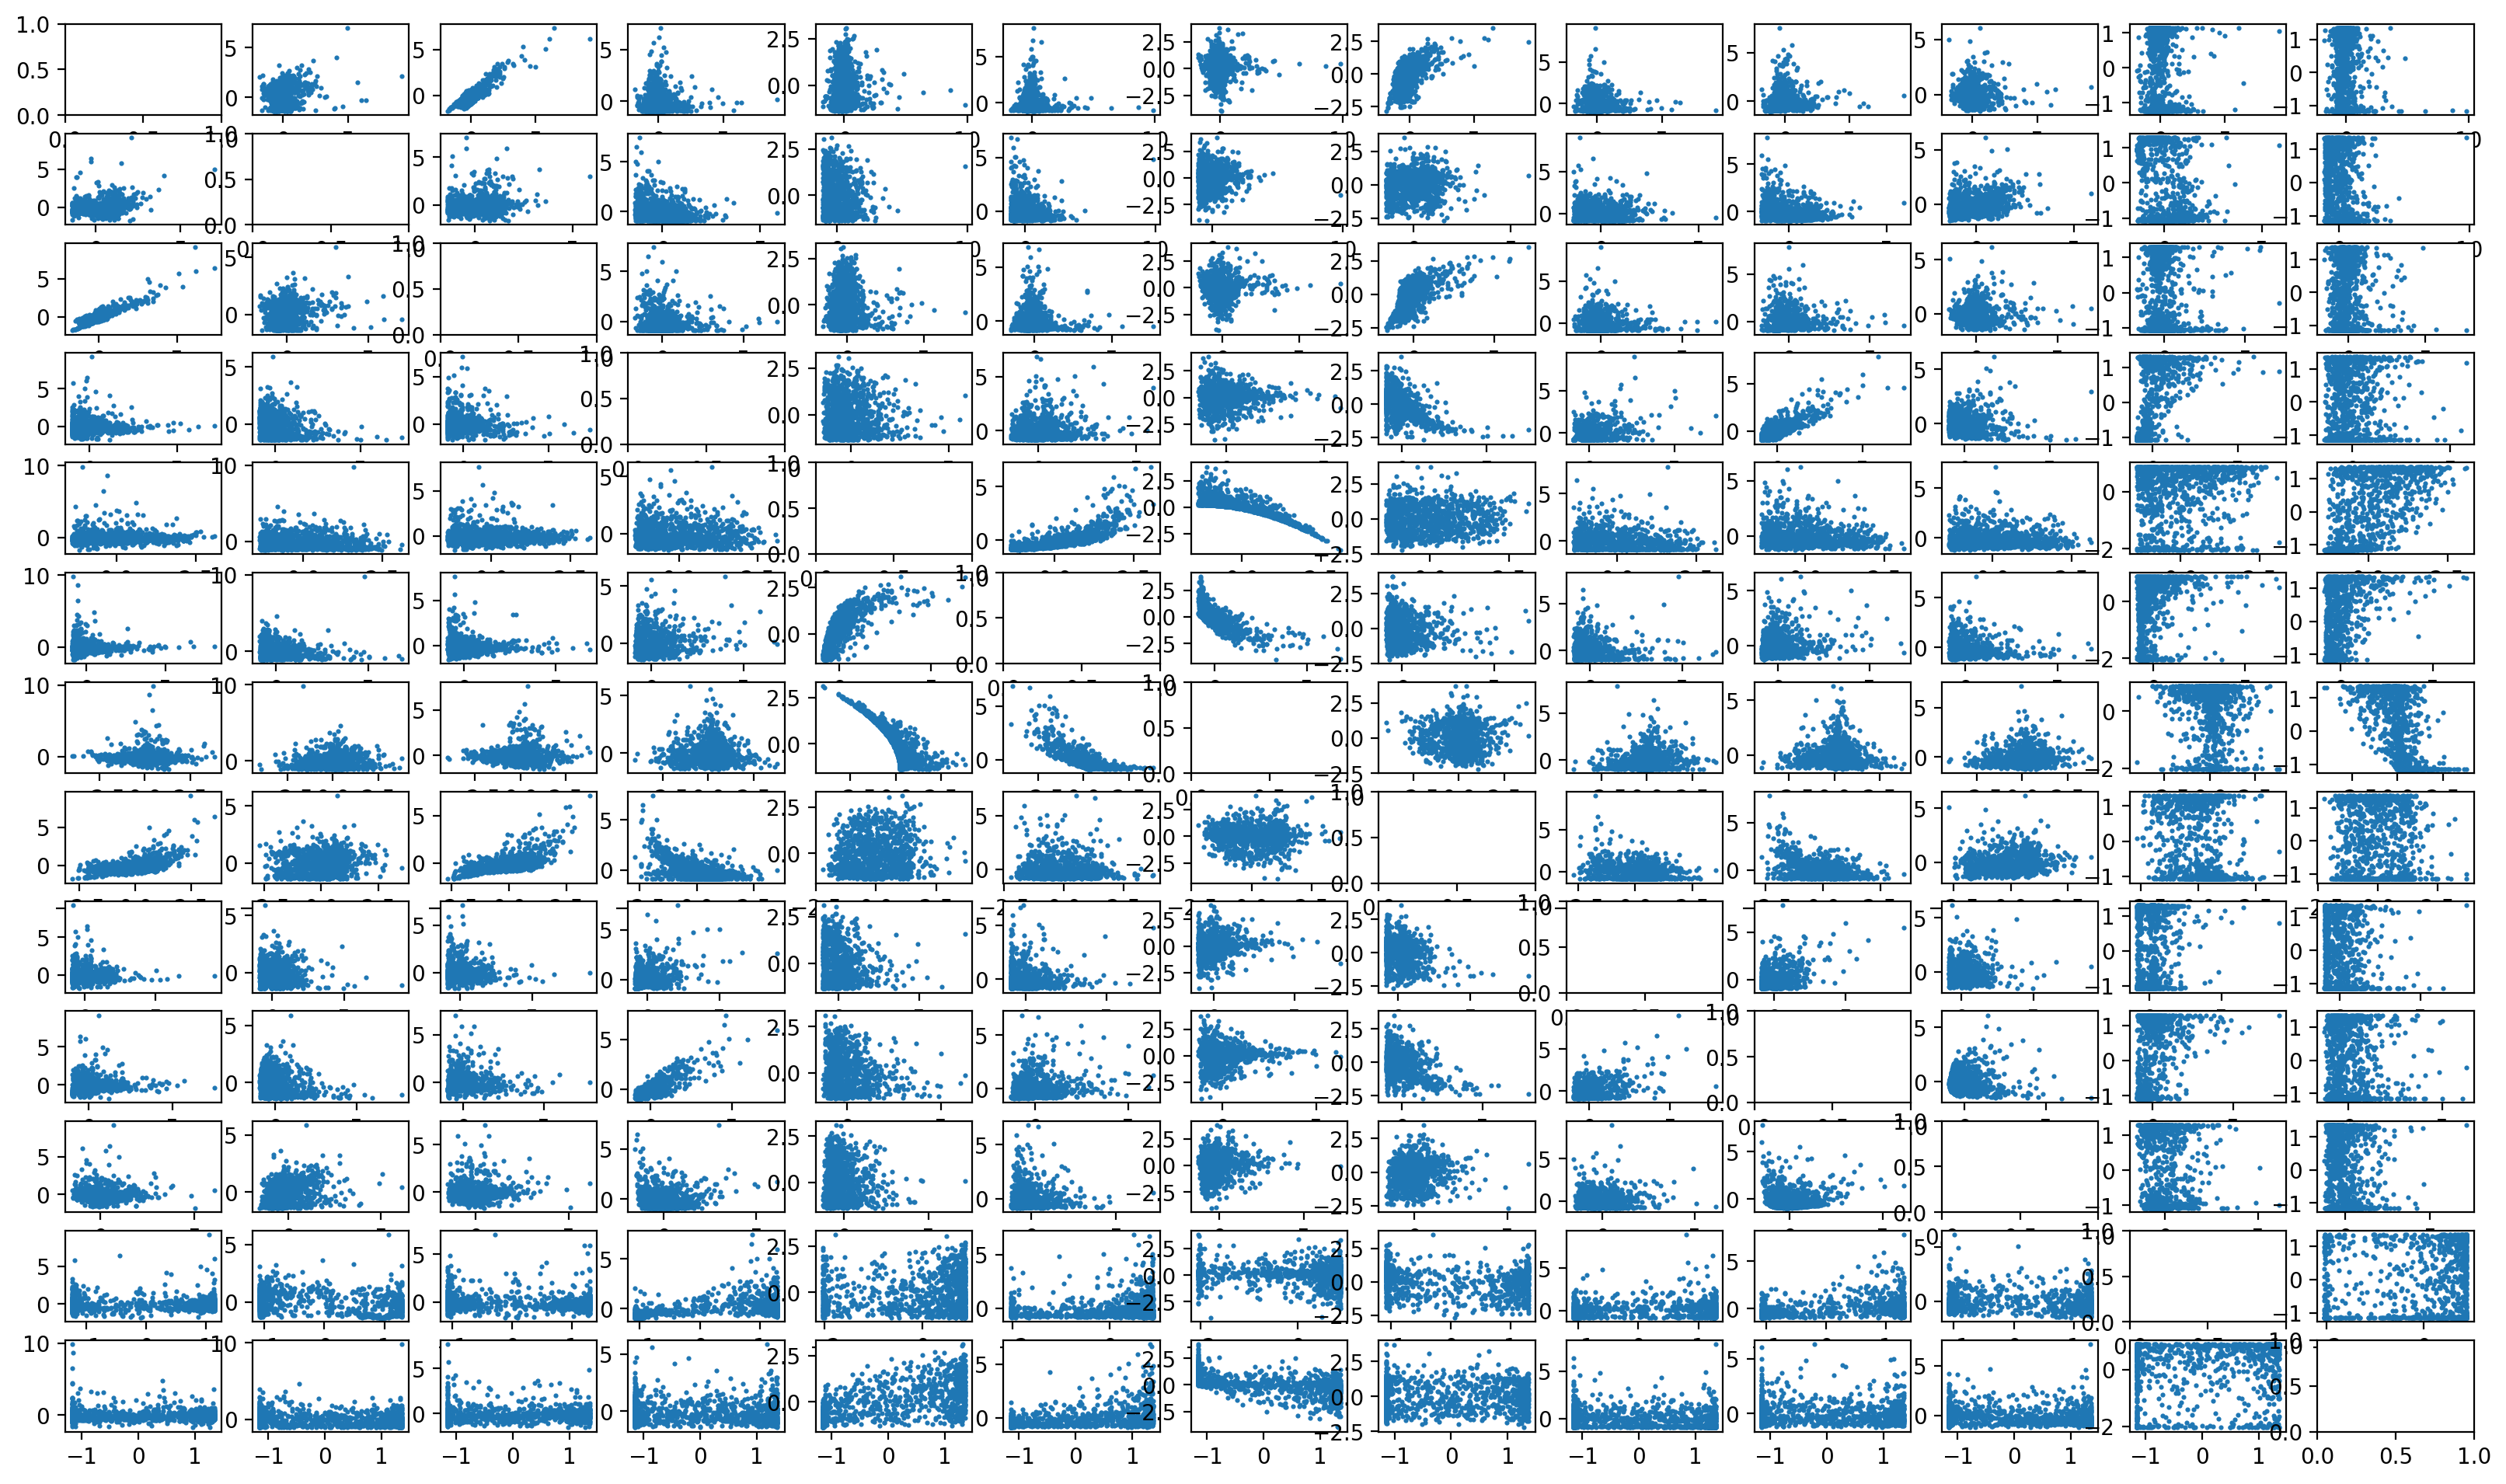

In [9]:
transposed = tX.T[:13]
fig = plt.figure(figsize=(20,12), dpi=200, facecolor='w', edgecolor='k')
axs = fig.subplots(13, 13)
for i, col1 in enumerate(transposed):
    for j, col2 in enumerate(transposed):
        if i != j:
            correlate(col1, col2, size=1000, axs=axs[i,j])
fig.savefig('corr.png')

# Notable correlation results

In [10]:
def correlate_features(i1, i2, size=None):
    plt.figure()
    plt.xlabel(feature_label(i1))
    plt.ylabel(feature_label(i2))
    correlate(tX[:,i1], tX[:,i2], size)

[[1.         0.91179511]
 [0.91179511 1.        ]]
[[ 1.         -0.83599277]
 [-0.83599277  1.        ]]
[[1.         0.79718078]
 [0.79718078 1.        ]]
[[1.         0.83273307]
 [0.83273307 1.        ]]


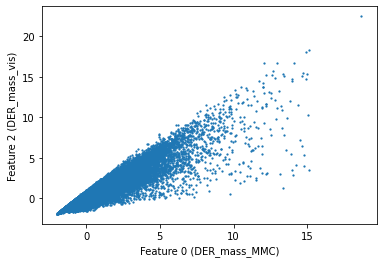

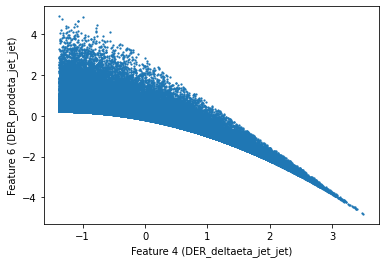

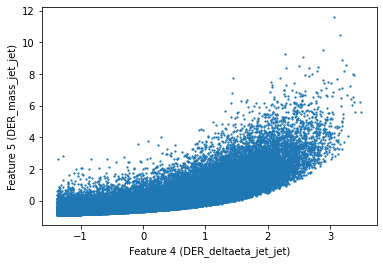

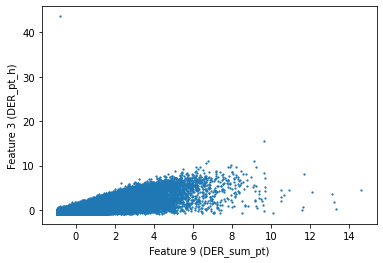

In [11]:
correlate_features(0, 2)
correlate_features(4, 6)
correlate_features(4, 5)
correlate_features(9, 3)

## Generate predictions and save ouput in csv format for submission:

In [13]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
y_test, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [36]:
def normalize(tX):
    return (tX - np.mean(tX, axis=0)) / np.std(tX, axis=0)

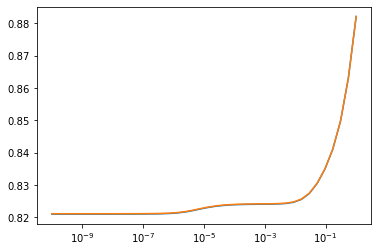

In [43]:
from validation import *

indices = build_k_indices(y, 10)

tX_normal = normalize(tX[:,:13])
lambdas = np.logspace(-10, 0, 40)
initial_w = np.zeros(tX_normal.shape[1])
results = np.vstack([
    cross_validation(y, tX_normal, indices, lambda y, tx: ridge_regression(y, tx, l))
    for l in lambdas
])

plt.semilogx(lambdas, results[:,0])
plt.semilogx(lambdas, results[:,1])
plt.show()
#np.vstack([
#    cross_validation(y, tX, indices, lambda y, tx: ridge_regression(y, tx, 0.01))
#    cross_validation(y, tX, indices, least_squares),
#    cross_validation(y, tX, indices, lambda y, tx: ridge_regression(y, tx, 0.01))
#])


In [31]:
OUTPUT_PATH = '' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)